# PopulationSim Validation Notebook

This notebook validates the results of the PopulationSim run for the "example_calm" scenario. It compares the synthetic population outputs against the controls and analyzes value distributions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set(style="whitegrid")
%matplotlib inline

## 1. Data Loading
Load the summary results, synthetic households, and seed households.

In [3]:
# Define paths
output_dir = 'output'
data_dir = 'data'

summary_taz_path = os.path.join(output_dir, 'final_summary_TAZ.csv')
synthetic_households_path = os.path.join(output_dir, 'synthetic_households.csv')
seed_households_path = os.path.join(data_dir, 'seed_households.csv')

# Check if files exist
for path in [summary_taz_path, synthetic_households_path, seed_households_path]:
    if not os.path.exists(path):
        print(f"Warning: File not found: {path}")

# Load data
df_summary = pd.read_csv(summary_taz_path)
df_synthetic = pd.read_csv(synthetic_households_path)
df_seed = pd.read_csv(seed_households_path)

print("Data loaded successfully.")
print(f"Summary TAZ shape: {df_summary.shape}")
print(f"Synthetic Households shape: {df_synthetic.shape}")
print(f"Seed Households shape: {df_seed.shape}")

Data loaded successfully.
Summary TAZ shape: (781, 47)
Synthetic Households shape: (62041, 8)
Seed Households shape: (4841, 198)


## 2. Validation Statistics
Calculate Mean % Difference, Standard Deviation, and RMSE for each control category across all TAZs.

In [4]:
def calculate_metrics(df, control_col, result_col):
    # Calculate difference
    diff = df[result_col] - df[control_col]
    
    # Calculate % diff (avoid division by zero)
    pct_diff = (diff / df[control_col]).replace([np.inf, -np.inf], np.nan) * 100
    
    # Metrics
    mean_pct_diff = pct_diff.mean()
    stdev_diff = diff.std()
    rmse = np.sqrt((diff ** 2).mean())
    
    return mean_pct_diff, stdev_diff, rmse, pct_diff

# Identify control columns
control_cols = [c for c in df_summary.columns if c.endswith('_control')]
metrics_data = []
diff_data = []

for col in control_cols:
    base_name = col.replace('_control', '')
    result_col = base_name + '_result'
    
    if result_col in df_summary.columns:
        mean_p_diff, std, rmse, pct_diff_series = calculate_metrics(df_summary, col, result_col)
        
        metrics_data.append({
            'Category': base_name,
            'Mean % Diff': mean_p_diff,
            'STDEV (Count)': std,
            'RMSE': rmse
        })
        
        # Store data for plotting
        temp_df = pd.DataFrame({
            'pct_diff': pct_diff_series,
            'Category': base_name
        })
        diff_data.append(temp_df)

df_metrics = pd.DataFrame(metrics_data).set_index('Category')
print("Validation Metrics:")
display(df_metrics.round(4))

Validation Metrics:


,Mean % Diff,STDEV (Count),RMSE
Category,,,
num_hh,0.0000,0.0000,0.0000
hh_size_1,-0.3051,0.2292,0.2291
hh_size_2,-0.0664,0.2926,0.2929
hh_size_3,0.5024,0.2581,0.2580
hh_size_4_plus,-0.0647,0.2769,0.2772
hh_age_15_24,6.1942,2.7094,2.7077
hh_age_25_54,0.1333,1.7048,1.7037
hh_age_55_64,-0.1818,0.6869,0.6864
hh_age_65_plus,0.0991,0.6273,0.6270


## 3. Validation Plots

### Box Plot of % Difference
Visualizing the distribution of percentage errors for each category across all TAZs.

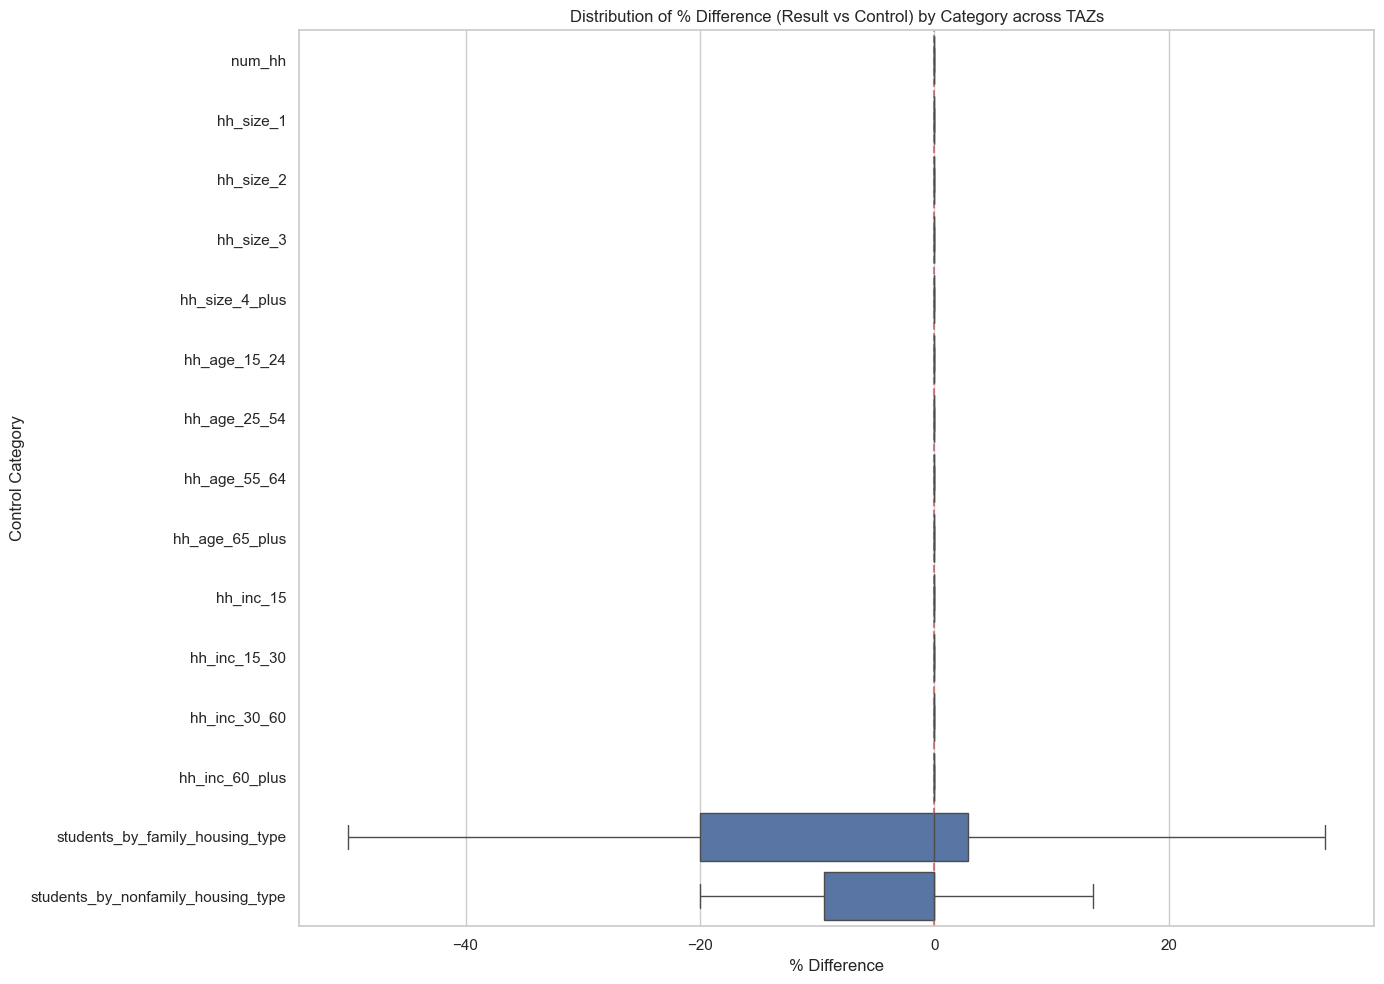

In [6]:
df_diff_long = pd.concat(diff_data, ignore_index=True)

plt.figure(figsize=(14, 10))
sns.boxplot(x='pct_diff', y='Category', data=df_diff_long, orient='h', showfliers=False)
plt.title('Distribution of % Difference (Result vs Control) by Category across TAZs')
plt.xlabel('% Difference')
plt.ylabel('Control Category')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.7)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

## 4. Expansion Factor Analysis
Checking how many times each seed household was replicated. This essentially visualizes the expansion factors.

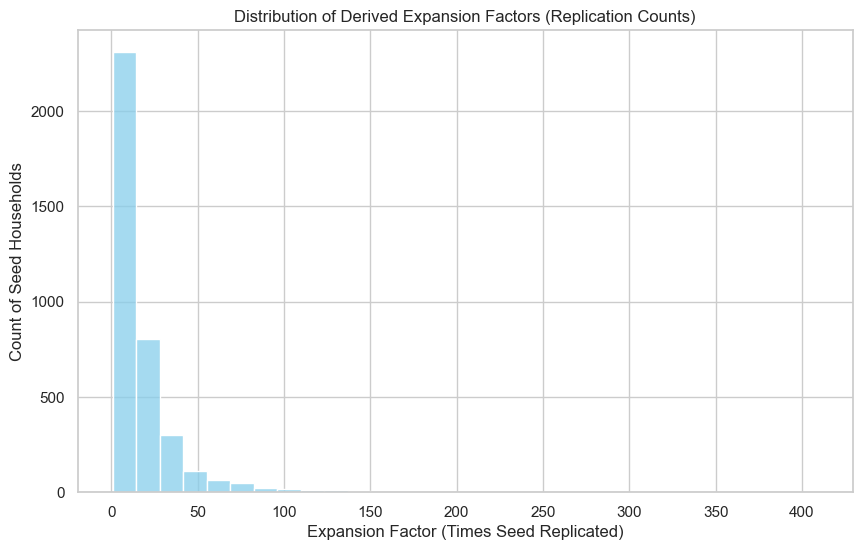

Stats for Expansion Factors:
Mean: 16.74
Median: 10.00
Min: 1
Max: 409
Std Dev: 22.45


In [8]:
# Load the expanded household IDs to get seed IDs
expanded_ids_path = os.path.join(output_dir, 'final_expanded_household_ids.csv')

if os.path.exists(expanded_ids_path):
    df_expanded = pd.read_csv(expanded_ids_path)
    # Count occurrences of each seed ID (hh_id) in the synthetic population
    expansion_factors = df_expanded['hh_id'].value_counts()

    plt.figure(figsize=(10, 6))
    sns.histplot(expansion_factors, bins=30, kde=False, color='skyblue')
    plt.title('Distribution of Derived Expansion Factors (Replication Counts)')
    plt.xlabel('Expansion Factor (Times Seed Replicated)')
    plt.ylabel('Count of Seed Households')
    plt.show()

    print(f"Stats for Expansion Factors:")
    print(f"Mean: {expansion_factors.mean():.2f}")
    print(f"Median: {expansion_factors.median():.2f}")
    print(f"Min: {expansion_factors.min()}")
    print(f"Max: {expansion_factors.max()}")
    print(f"Std Dev: {expansion_factors.std():.2f}")
else:
    print(f"Error: {expanded_ids_path} not found. Cannot calculate expansion factors.")